### Personalized Diabetes Management with Digital Twins: A Patient-Centric Knowledge Graph Approach

https://www.mdpi.com/2075-4426/14/4/359

In [1]:
import os
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

2025-07-27 17:29:53.785327: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 17:29:53.792933: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 17:29:53.796100: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 17:29:53.803407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753617593.815715  111092 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753617593.81

In [2]:
class DataPreprocessing:
    def __init__(self,Cleaned=False):
        self.Cleaned = Cleaned
        self.insulin_cols = [
                'insulin dose - s.c.',
                'non-insulin hypoglycemic agents',
                'csii - bolus insulin (novolin r, iu)',
                'csii - basal insulin (novolin r, iu / h)',
                'insulin dose - i.v.'
            ]

    def extract_iu_number(self,text):
        if isinstance(text, str):
            match = re.search(r'(\d+)\s*iu', text, re.IGNORECASE)
            return int(match.group(1)) if match else 0
        return text

    def data_cleaning(self,df):
        ### TODO_Later : apply for all merged columns
        df["csii - basal insulin (novolin r, iu / h)"]=df['csii - basal insulin (novolin r, iu / h)'].ffill()

        for col in df.columns:
            df[col] = df[col].apply(lambda x: 0 if isinstance(x, str) and x.strip().lower() in [
                "data not available", "temporarily suspend Insulin delivery"
            ] else x)
            df[col] = df[col].apply(self.extract_iu_number)

        df.fillna(0, inplace=True)
        return df

    def preprocess(self,df):
        df.columns = df.columns.str.strip().str.lower()
        if not self.Cleaned:
            df = self.data_cleaning(df)
        df['Glucose'] = df.apply( lambda row: row['cbg (mg / dl)'] if row['cbg (mg / dl)'] != 0 else row['cgm (mg / dl)'],axis=1)
        df['TimeStamp'] = pd.to_datetime(df['date'])
        df = df.sort_values('TimeStamp').reset_index(drop=True)
        df["Insulin"] = df[self.insulin_cols].sum(axis=1)
        df.rename(columns={col: 'Meal' for col in df.columns if 'dietary intake' in col.lower()},inplace=True )
        df = df.drop(columns=['date', 'cgm (mg / dl)', 'cbg (mg / dl)','blood ketone (mmol / l)'] + self.insulin_cols)
        return df

In [3]:
"""
Approch to create the PHKg:
    step1 : create glucose node for every TimeStamp
    step2 : create nodes like meal and insulin
    step3 :  connect the nodes created in step2 to step1 using some relation (affect,etc)
    step4 : create a mesh by connecting the next glucode node to the previous one

"""

class PHKg:
    def __init__(self):
        self.G = nx.DiGraph()

    def build(self, df):
        self.G.clear()

        for i, row in df.iterrows():
            ts = row['TimeStamp'].strftime('%Y-%m-%d %H:%M:%S')

            # Glucose node
            glucose = row['Glucose']
            self.G.add_node(f"Glucose|{ts}", type="observation", value=glucose)

            # Meal node
            if row['Meal'] > 0:
                self.G.add_node(f"Meal|{ts}", type="event", value=row['Meal'])
                self.G.add_edge(f"Meal|{ts}", f"Glucose|{ts}", relation="affects")

            # Insulin node
            if row["Insulin"] > 0:
                self.G.add_node(f"Insulin|{ts}", type="event", value=row["Insulin"] )
                self.G.add_edge(f"Insulin|{ts}", f"Glucose|{ts}", relation="cure")

            # connect with prev node
            if i > 0:
                prev_ts = df.loc[i-1, 'TimeStamp'].strftime('%Y-%m-%d %H:%M:%S')
                self.G.add_edge(f"Glucose|{prev_ts}", f"Glucose|{ts}", relation="next")



    def visualize(self, max_nodes=50):
        sub_nodes = list(self.G.nodes)[:max_nodes]
        subG = self.G.subgraph(sub_nodes)

        plt.figure(figsize=(15, 10))
        pos = nx.spring_layout(subG, seed=42)

        node_colors = []
        for _, attrs in subG.nodes(data=True):
            if attrs['type'] == "observation":
                node_colors.append("skyblue")
            elif attrs['type'] == "event":
                node_colors.append("lightgreen")
            else:
                node_colors.append("lightgrey")

        nx.draw(subG, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=8, edge_color='gray')
        nx.draw_networkx_edge_labels(
            subG, pos,
            edge_labels={(u, v): d['relation'] for u, v, d in subG.edges(data=True)},
            font_size=7
        )

        plt.title("Subgraph of Personal Health Knowledge Graph (PHKG)")
        plt.axis("off")
        plt.show()

    def get_graph(self):
        return self.G


In [5]:
import keras_tuner as kt

class LSTM_Model:
    def __init__(self, X, y, scaler):
        self.X = X
        self.y = y
        self.scaler = scaler
        self.model = None
        self.history = None
        self.y_pred = None
        self.result = None

    def _build_model(self, hp):
        model = Sequential()
        model.add(tf.keras.Input(shape=(self.X.shape[1], self.X.shape[2])))

        model.add(LSTM(units=hp.Int('lstm1_units', 32, 128, step=32),
                       return_sequences=True,
                       activation=hp.Choice('lstm1_activation', ['tanh', 'relu'])))

        model.add(LSTM(units=hp.Int('lstm2_units', 16, 64, step=16),
                       activation=hp.Choice('lstm2_activation', ['tanh', 'relu'])))

        model.add(Dense(units=hp.Int('dense_units', 16, 64, step=16),
                        activation=hp.Choice('dense_activation', ['elu', 'relu', 'tanh'])))

        model.add(Dense(1))  # Output

        model.compile(
            optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
            loss='mse'
        )
        return model

    def Train(self, test_size=None, tune=False, max_trials=5):
        if test_size is not None:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                self.X, self.y, test_size=test_size, shuffle=False
            )
        else:
            self.X_train, self.y_train = self.X, self.y
            self.X_test = self.y_test = None

        if tune:
            self._tune_hyperparameters(max_trials=max_trials)
        else:
            # Default architecture
            self.model = Sequential([
                tf.keras.Input(shape=(self.X.shape[1], self.X.shape[2])),
                LSTM(64, return_sequences=True, activation='tanh'),
                LSTM(32, activation='tanh'),
                Dense(32, activation='elu'),
                Dense(1)
            ])
            self.model.compile(optimizer='RMSProp', loss='mse')
            self.history = self.model.fit(
                self.X_train, self.y_train,
                epochs=20,
                batch_size=16,
            )

    def _tune_hyperparameters(self, max_trials=5):
        class PrintRMSECallback(tf.keras.callbacks.Callback):
            def __init__(self, X_val, y_val, scaler):
                self.X_val = X_val
                self.y_val = y_val
                self.scaler = scaler

            def on_epoch_end(self, epoch, logs=None):
                y_pred = self.model.predict(self.X_val, verbose=0).flatten()
                glucose_min = self.scaler.data_min_[0]
                glucose_max = self.scaler.data_max_[0]
                y_pred_denorm = glucose_min + y_pred * (glucose_max - glucose_min)
                y_val_denorm = glucose_min + self.y_val.flatten() * (glucose_max - glucose_min)
                rmse = np.sqrt(mean_squared_error(y_val_denorm, y_pred_denorm))
                print(f"Trial Epoch {epoch + 1}: RMSE = {rmse:.2f} mg/dL")

        tuner = kt.RandomSearch(
            self._build_model,
            objective='val_loss',
            max_trials=max_trials,
            executions_per_trial=1,
            overwrite=True,
            directory='tuner_logs',
            project_name='lstm_tuning'
        )

        tuner.search(self.X_train, self.y_train,
                     validation_split=0.2,
                     epochs=10,
                     batch_size=16,
                     callbacks=[
                         PrintRMSECallback(self.X_train[-int(0.2 * len(self.X_train)):], 
                                           self.y_train[-int(0.2 * len(self.y_train)):], 
                                           self.scaler)
                     ],
                     verbose=1)

        best_hp = tuner.get_best_hyperparameters(1)[0]
        self.model = tuner.hypermodel.build(best_hp)
        self.history = self.model.fit(self.X_train, self.y_train, epochs=20, batch_size=16)

    def Evaluate(self):
        self.y_pred = self.model.predict(self.X_test)

        glucose_min = self.scaler.data_min_[0]
        glucose_max = self.scaler.data_max_[0]
        range_ = glucose_max - glucose_min

        y_pred_denorm = glucose_min + self.y_pred.flatten() * range_
        y_test_denorm = glucose_min + self.y_test.flatten() * range_

        rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
        mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
        r2 = r2_score(y_test_denorm, y_pred_denorm)

        print("\n📊 Evaluation on Test Set:")
        print("-" * 40)
        print(f"RMSE         : {rmse:.2f} mg/dL")
        print(f"MAE          : {mae:.2f} mg/dL")
        print(f"R² Score     : {r2:.4f}")
        print(f"Min Glucose  : {y_pred_denorm.min():.2f} mg/dL")
        print(f"Max Glucose  : {y_pred_denorm.max():.2f} mg/dL")
        print("-" * 40)

    def Plot_Test_Prediction(self):
        if self.y_pred is None:
            print("❌ Prediction not available. Run Evaluate() first.")
            return

        glucose_min = self.scaler.data_min_[0]
        glucose_max = self.scaler.data_max_[0]
        range_ = glucose_max - glucose_min

        y_pred_denorm = glucose_min + self.y_pred.flatten() * range_
        y_test_denorm = glucose_min + self.y_test.flatten() * range_

        plt.figure(figsize=(12, 5))
        plt.plot(y_test_denorm, label='Actual Glucose')
        plt.plot(y_pred_denorm, label='Predicted Glucose')
        plt.title("Test Set Prediction: Actual vs Predicted")
        plt.xlabel("Time Step")
        plt.ylabel("Glucose (mg/dL)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def Predict(self, normalized_data, meal_t, insulin_t):
        last_5 = normalized_data[-5:]
        last_glucose = last_5[-1][0]

        current_input_raw = np.array([[last_glucose, meal_t, insulin_t]])
        normalized_current = self.scaler.transform(current_input_raw)

        norm_glucose = normalized_current[0][0]
        norm_meal = normalized_current[0][1]
        norm_insulin = normalized_current[0][2]
        current_data = np.array([norm_glucose, norm_meal, norm_insulin]).reshape(1, 3)
        input_sequence = np.vstack([last_5, current_data])

        pred_norm = self.model.predict(input_sequence.reshape(1, 6, 3), verbose=0)[0][0]

        glucose_min, glucose_max = self.scaler.data_min_[0], self.scaler.data_max_[0]
        glucose_range = glucose_max - glucose_min
        predicted_glucose = glucose_min + pred_norm * glucose_range if glucose_range > 0 else glucose_min
        predicted_glucose = round(predicted_glucose, 2)

        risk = (
            "hypo" if predicted_glucose < 70 else
            "normal" if predicted_glucose <= 180 else
            "hyper"
        )

        new_step = np.array([pred_norm, norm_meal, norm_insulin])
        updated_sequence = np.vstack([last_5[1:], new_step])

        self.result = {
            "glucose": predicted_glucose,
            "meal": meal_t,
            "insulin": insulin_t,
            "risk": risk
        }

        self._format_prediction_output()
        return updated_sequence

    def _format_prediction_output(self):
        print("\n🧪 Glucose Prediction Result")
        print("-" * 35)
        print(f"{'Glucose Level':15}: {self.result['glucose']} mg/dL")
        print(f"{'Meal Intake':15}: {self.result['meal']} grams")
        print(f"{'Insulin Dose':15}: {self.result['insulin']} IU")
        print(f"{'Risk Level':15}: {self.result['risk'].upper()}")
        print("-" * 35)

    def GetModel(self):
        return self.model

    def save_model(self, path):
        self.model.save(path)


In [4]:
class LSTM_ModelData:
    def __init__(self,FromGraph=True):
        self.FromGraph = FromGraph


    def extract_data_from_graph(self,G):
        data = []

        for node in G.nodes(data=True):
            if node[1]["type"] == "observation" and "Glucose" in node[0]:
                TimeStamp = node[0].split("|")[1].strip()
                glucose = node[1]["value"]
                event = {
                    "TimeStamp": pd.to_datetime(TimeStamp),
                    "Glucose": glucose,
                    "Meal": 0,
                    "Insulin": 0,
                }

                # Look  for meal or insulin inputs
                for pred in G.predecessors(node[0]):
                    if "Meal" in pred:
                        event["Meal"] = G.nodes[pred]["value"]
                    if "Insulin" in pred:
                        event["Insulin"] = G.nodes[pred]["value"]

                data.append(event)

        ts_df = pd.DataFrame(data).sort_values("TimeStamp").reset_index(drop=True)
        return ts_df



    def Prepare_Data(self,sequence_length=5,df=None,Graph=None):
        if self.FromGraph and Graph is not None:
            df = self.extract_data_from_graph(Graph)
        elif df is None:
            raise ValueError("Either df or G must be provided")


        features = ['Glucose', 'Meal', 'Insulin']
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[features])
        X, y = [], []

        for i in range(sequence_length, len(normalized_data)):
            # Get past 5 timesteps
            past_sequence = normalized_data[i-sequence_length:i]

            # Current meal and insulin at time t
            curr_meal = normalized_data[i, 1]
            curr_insulin = normalized_data[i, 2]
            curr_glucose_dummy = past_sequence[-1][0]

            current_step = np.array([curr_glucose_dummy, curr_meal, curr_insulin]).reshape(1, 3)

            # Combine to form full sequence
            full_sequence = np.vstack([past_sequence, current_step])  # shape (6, 3)

            X.append(full_sequence)
            y.append(normalized_data[i][0])  # target: glucose at time t


        return np.array(X), np.array(y), scaler, normalized_data



In [5]:

class LSTM_Model:
    def __init__(self, X, y, scaler):
        self.X = X
        self.y = y
        self.scaler = scaler
        self.model = None
        self.history = None
        self.y_pred = None
        self.result = None

    def Train(self, test_size=None):
        if test_size is not None:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                self.X, self.y, test_size=test_size, shuffle=False
            )
        else:
            self.X_train, self.y_train = self.X, self.y

        self.model = Sequential([
            tf.keras.Input(shape=(self.X.shape[1], self.X.shape[2])),
            LSTM(64, activation='tanh'),
            Dense(32, activation='tanh'),
            Dense(1, activation="tanh"),
        ])

        self.model.compile(optimizer='adam', loss='mse')
        self.history = self.model.fit(
            self.X_train, self.y_train,
            epochs=20,
            batch_size=16,
        )

    def Evaluate(self):
        self.y_pred = self.model.predict(self.X_test)

        glucose_min = self.scaler.data_min_[0]
        glucose_max = self.scaler.data_max_[0]
        range_ = glucose_max - glucose_min

        y_pred_denorm = glucose_min + self.y_pred.flatten() * range_
        y_test_denorm = glucose_min + self.y_test.flatten() * range_

        rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
        mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
        r2 = r2_score(y_test_denorm, y_pred_denorm)

        print("\n📊 Evaluation on Test Set:")
        print("-" * 40)
        print(f"RMSE         : {rmse:.2f} mg/dL")
        print(f"MAE          : {mae:.2f} mg/dL")
        print(f"R² Score     : {r2:.4f}")
        print(f"Min Glucose  : {y_pred_denorm.min():.2f} mg/dL")
        print(f"Max Glucose  : {y_pred_denorm.max():.2f} mg/dL")
        print("-" * 40)

    def Plot_Test_Prediction(self):
        if self.y_pred is None:
            print("❌ Prediction not available. Run Evaluate() first.")
            return

        glucose_min = self.scaler.data_min_[0]
        glucose_max = self.scaler.data_max_[0]
        range_ = glucose_max - glucose_min

        y_pred_denorm = glucose_min + self.y_pred.flatten() * range_
        y_test_denorm = glucose_min + self.y_test.flatten() * range_

        plt.figure(figsize=(12, 5))
        plt.plot(y_test_denorm, label='Actual Glucose')
        plt.plot(y_pred_denorm, label='Predicted Glucose')
        plt.title("Test Set Prediction: Actual vs Predicted")
        plt.xlabel("Time Step")
        plt.ylabel("Glucose (mg/dL)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def Predict(self, normalized_data, meal_t, insulin_t):
        last_5 = normalized_data[-5:]
        last_glucose = last_5[-1][0]

        current_input_raw = np.array([[last_glucose, meal_t, insulin_t]])
        normalized_current = self.scaler.transform(current_input_raw)

        norm_glucose = normalized_current[0][0]
        norm_meal = normalized_current[0][1]
        norm_insulin = normalized_current[0][2]
        current_data = np.array([norm_glucose, norm_meal, norm_insulin]).reshape(1, 3)
        input_sequence = np.vstack([last_5, current_data])

        pred_norm = self.model.predict(input_sequence.reshape(1, 6, 3), verbose=0)[0][0]

        glucose_min, glucose_max = self.scaler.data_min_[0], self.scaler.data_max_[0]
        glucose_range = glucose_max - glucose_min
        predicted_glucose = glucose_min + pred_norm * glucose_range if glucose_range > 0 else glucose_min
        predicted_glucose = round(predicted_glucose, 2)

        risk = (
            "hypo" if predicted_glucose < 70 else
            "normal" if predicted_glucose <= 180 else
            "hyper"
        )

        new_step = np.array([pred_norm, norm_meal, norm_insulin])
        updated_sequence = np.vstack([last_5[1:], new_step])

        self.result = {
            "glucose": predicted_glucose,
            "meal": meal_t,
            "insulin": insulin_t,
            "risk": risk
        }

        self._format_prediction_output()
        return updated_sequence

    def _format_prediction_output(self):
        print("\n🧪 Glucose Prediction Result")
        print("-" * 35)
        print(f"{'Glucose Level':15}: {self.result['glucose']} mg/dL")
        print(f"{'Meal Intake':15}: {self.result['meal']} grams")
        print(f"{'Insulin Dose':15}: {self.result['insulin']} IU")
        print(f"{'Risk Level':15}: {self.result['risk'].upper()}")
        print("-" * 35)

    def GetModel(self):
        return self.model

    def save_model(self, path):
        self.model.save(path)


In [6]:
## Preprocessing data
df = pd.read_excel("/mnt/utsav_raj/Data_Science/Digital_Twin/Data/patient_1.xlsx")
preprocessor = DataPreprocessing(Cleaned=True)
df = preprocessor.preprocess(df)

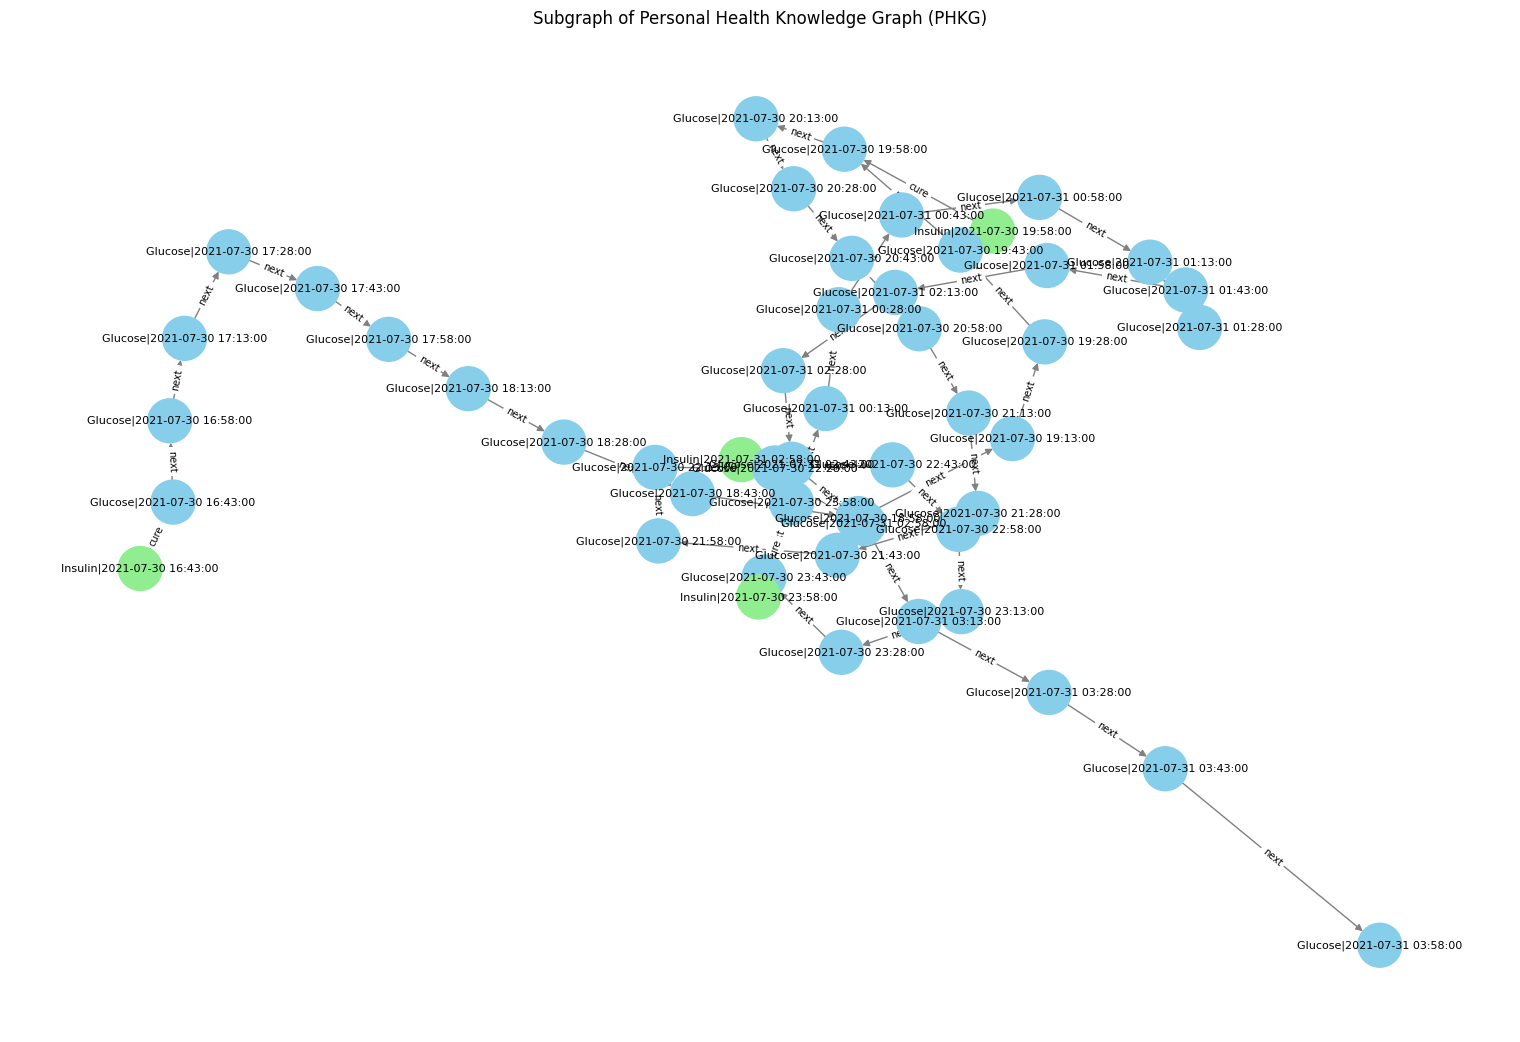

In [7]:
## Building Phkg
PHKg = PHKg()
PHKg.build(df)
PHKg.visualize(max_nodes=50)
G = PHKg.get_graph()

In [8]:
## Preparing data for the model
LSTM_Model_Data = LSTM_ModelData(FromGraph=True)
X,y,scaler,normalized_data = LSTM_Model_Data.Prepare_Data(sequence_length=10,Graph=G)

In [9]:
# Train model
model = LSTM_Model(X, y, scaler)
model.Train(test_size=0.2, tune=True, max_trials=10)

TypeError: LSTM_Model.Train() got an unexpected keyword argument 'tune'

In [10]:
model.Evaluate()
model.Plot_Test_Prediction()

AttributeError: 'NoneType' object has no attribute 'predict'

In [11]:
## Retaining the model on full data
model = LSTM_Model(X, y, scaler)
model.Train()

Epoch 1/20


E0000 00:00:1753617631.157760  111092 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753617631.160808  111092 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0609  
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051
Epoch 13/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052
Epoch 14/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 15/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 16/20
41/41 ━━━━━━━━━━

In [12]:
## Prediction using the model
new_seq = normalized_data
new_seq = model.Predict(new_seq,meal_t=0,insulin_t=0.7)

/mnt/utsav_raj/Data_Science/.mvenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



🧪 Glucose Prediction Result
-----------------------------------
Glucose Level  : 169.1 mg/dL
Meal Intake    : 0 grams
Insulin Dose   : 0.7 IU
Risk Level     : NORMAL
-----------------------------------
